In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim

import time, os
from tqdm import tqdm

In [2]:
import nflib
from nflib.flows import SequentialFlow, NormalizingFlow, ActNorm, AffineConstantFlow
import nflib.coupling_flows as icf
import nflib.inn_flow as inn
import nflib.res_flow as irf

In [3]:
from torch import distributions
from torch.distributions import MultivariateNormal

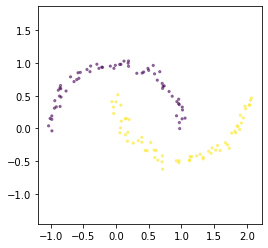

In [4]:
# Lightweight datasets
from sklearn import datasets

class DatasetMoons:
    """ two half-moons """
    def sample(self, n):
        moons = datasets.make_moons(n_samples=n, noise=0.05)
        x,c = moons
        x = x.astype(np.float32)
        c = c.astype(np.long)
        return torch.from_numpy(x), torch.from_numpy(c)

# class DatasetMixture:
#     """ 4 mixture of gaussians """
#     def sample(self, n):
#         assert n%4 == 0
#         r = np.r_[np.random.randn(n // 4, 2)*0.5 + np.array([0, -2]),
#                   np.random.randn(n // 4, 2)*0.5 + np.array([0, 0]),
#                   np.random.randn(n // 4, 2)*0.5 + np.array([2, 2]),
#                   np.random.randn(n // 4, 2)*0.5 + np.array([-2, 2])]
#         return torch.from_numpy(r.astype(np.float32))

d = DatasetMoons()
#d = DatasetMixture()

x,c = d.sample(128)
plt.figure(figsize=(4,4))
plt.scatter(x[:,0], x[:,1], s=5, alpha=0.5, c=c)
plt.axis('equal');

In [15]:
prior = MultivariateNormal(torch.zeros(2), torch.eye(2))

actf = irf.Swish
flows = [
    ActNorm(2),
    irf.ResidualFlow(2, [100], activation=actf),
    ActNorm(2),
    irf.ResidualFlow(2, [100], activation=actf),
    ActNorm(2),
#     irf.ResidualFlow(2, [100], activation=actf),
#     ActNorm(2),
#     irf.ResidualFlow(2, [100], activation=actf),
#     ActNorm(2),
        ]

model = SequentialFlow(flows)

In [16]:
model

SequentialFlow(
  (flows): ModuleList(
    (0): ActNorm()
    (1): ResidualFlow(
      (resblock): ModuleList(
        (0): Linear(in_features=2, out_features=100, bias=True)
        (1): Swish()
        (2): Linear(in_features=100, out_features=2, bias=True)
      )
    )
    (2): ActNorm()
    (3): ResidualFlow(
      (resblock): ModuleList(
        (0): Linear(in_features=2, out_features=100, bias=True)
        (1): Swish()
        (2): Linear(in_features=100, out_features=2, bias=True)
      )
    )
    (4): ActNorm()
  )
)

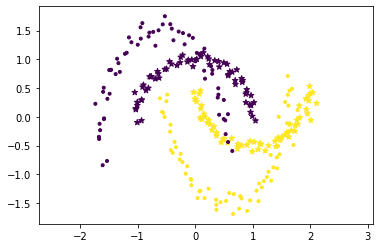

In [17]:
x,c = d.sample(128)
z, logDetJ = model(x, True)
z = z.data.detach()
plt.scatter(x[:,0], x[:,1], marker='*', c=c)
plt.scatter(z[:,0], z[:,1], marker='.', c=c)
plt.axis('equal');

In [18]:
# jpt text to stop execution

## Model Train

In [19]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5) # todo tune WD
# optimizer = optim.SGD(model.parameters(), lr=0.1)
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  1018


In [20]:
model.train()
losses = []
NUM = 512
for k in tqdm(range(1000*2+1)):
    optimizer.zero_grad()
    
    x,c = d.sample(NUM)
    z = model(x, False)
    
#     y = torch.sigmoid(torch.sum(z, dim=1))
    y = torch.sigmoid(z[:,0])
    loss = criterion(y, c.type(y.dtype))
    loss.backward()
    optimizer.step()

    if k % 200 == 0:
        losses.append(float(loss))
        print("Loss:", k, losses[-1])
        print("logDetJ:", logDetJ.data.min(), logDetJ.data.max())


  1%|▏         | 28/2001 [00:00<00:14, 135.07it/s]

Loss: 0 0.5037742257118225
logDetJ: tensor(0.8065) tensor(0.8276)


 11%|█         | 221/2001 [00:01<00:12, 140.62it/s]

Loss: 200 0.25426676869392395
logDetJ: tensor(0.8065) tensor(0.8276)


 21%|██▏       | 430/2001 [00:03<00:11, 139.36it/s]

Loss: 400 0.23701804876327515
logDetJ: tensor(0.8065) tensor(0.8276)


 31%|███       | 623/2001 [00:04<00:09, 140.49it/s]

Loss: 600 0.23929443955421448
logDetJ: tensor(0.8065) tensor(0.8276)


 41%|████      | 818/2001 [00:05<00:08, 142.87it/s]

Loss: 800 0.24795661866664886
logDetJ: tensor(0.8065) tensor(0.8276)


 51%|█████▏    | 1028/2001 [00:07<00:07, 138.49it/s]

Loss: 1000 0.2337711751461029
logDetJ: tensor(0.8065) tensor(0.8276)


 61%|██████    | 1215/2001 [00:08<00:06, 130.75it/s]

Loss: 1200 0.2377573549747467
logDetJ: tensor(0.8065) tensor(0.8276)


 71%|███████   | 1416/2001 [00:10<00:04, 132.29it/s]

Loss: 1400 0.0939033031463623
logDetJ: tensor(0.8065) tensor(0.8276)


 81%|████████  | 1616/2001 [00:11<00:02, 135.96it/s]

Loss: 1600 0.020207175984978676
logDetJ: tensor(0.8065) tensor(0.8276)


 91%|█████████ | 1814/2001 [00:13<00:01, 119.86it/s]

Loss: 1800 0.006288727279752493
logDetJ: tensor(0.8065) tensor(0.8276)


100%|██████████| 2001/2001 [00:15<00:00, 132.73it/s]

Loss: 2000 0.002677766140550375
logDetJ: tensor(0.8065) tensor(0.8276)


In [11]:
asdfsdf

NameError: name 'asdfsdf' is not defined

In [ ]:
plt.plot(losses)

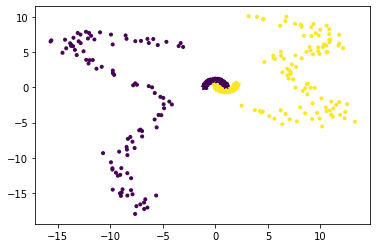

In [21]:
with torch.no_grad():
    x,c = d.sample(200)
    z = model(x, False)
plt.scatter(x[:,0], x[:,1], marker='*', c=c)
plt.scatter(z[:,0], z[:,1], marker='.', c=c)   

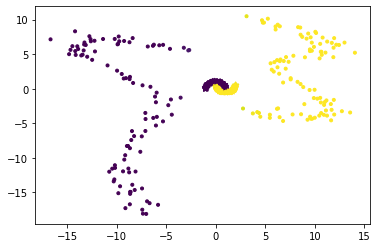

In [25]:
with torch.no_grad():
    x,c = d.sample(200)
    z = model(x, False)
    y = torch.sigmoid(z[:,0])
plt.scatter(x[:,0], x[:,1], marker='*', c=y.reshape(-1))
plt.scatter(z[:,0], z[:,1], marker='.', c=y.reshape(-1))   

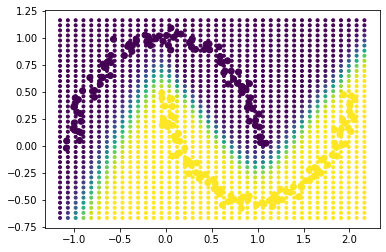

In [34]:
model.eval()

ng = 40
_a,_b,_c,_d = x[:,0].min()-0.1,x[:,0].max()+0.1,x[:,1].min()-0.1,x[:,1].max()+0.1
xx, yy = np.linspace(_a, _b, ng), np.linspace(_c, _d, ng)
xv, yv = np.meshgrid(xx, yy)
xy = np.stack([xv.reshape(-1), yv.reshape(-1)], axis=-1)
x = torch.Tensor(xy)

with torch.no_grad():
#     x,c = d.sample(200)
    z = model(x, False)
    y = torch.sigmoid(z[:,0])
    
plt.scatter(x[:,0], x[:,1], marker='.', c=y.reshape(-1))
x,c = d.sample(200)
plt.scatter(x[:,0], x[:,1], marker='o', c=c.reshape(-1))

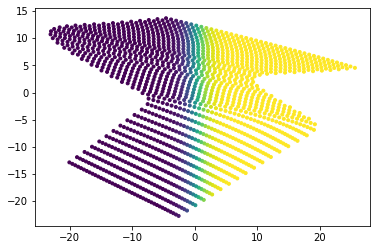

In [35]:
plt.scatter(z[:,0], z[:,1], marker='.', c=y.reshape(-1))   

In [ ]:
model.eval()

ng = 20
_a,_b,_c,_d = x[:,0].min()-0.1,x[:,0].max()+0.1,x[:,1].min()-0.1,x[:,1].max()+0.1
xx, yy = np.linspace(_a, _b, ng), np.linspace(_c, _d, ng)
xv, yv = np.meshgrid(xx, yy)
xy = np.stack([xv.reshape(-1), yv.reshape(-1)], axis=-1)
x = torch.Tensor(xy)
z = model(x)
print(z.shape)

x = x.detach().numpy()
z = z.detach().numpy()
plt.figure(figsize=(20,20))
plt.scatter(z[:,0], z[:,1], c='r', s=5)
z = z.reshape(ng, ng, -1)
for i in range(ng):
    plt.plot(z[:, i, 0], z[:, i, 1], marker='.')
for i in range(ng):
    plt.plot(z[i, :, 0], z[i, :, 1], marker='.')
    
plt.title('x -> z')